In [67]:
# Homework 3
# COMP 546
# Kevin McCoy

In [106]:
# imports

import numpy as np
from numpy import linalg as LA
from scipy import signal
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.signal import butter, filtfilt
import imageio
from math import floor

# Problem 1

In [107]:
# Problem 1.1


def read_video_into_numpy(filename):
  cap = cv2.VideoCapture(filename)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    frame = frame.astype('float32')
    frames.append(frame)

  cap.release()
  video = np.stack(frames, axis=0)#converts to numpy array(T,H,W,C)
  video = np.transpose(video, (1,2,3,0))#(T,H,W,C)->(H,W,C,T)
  return frames


def bandpass_filter(signal, low_cutoff, high_cutoff, fs, order):
  nyquist = 0.5 * fs
  low = low_cutoff / nyquist
  high = high_cutoff / nyquist
  b, a = butter(order, [low, high], btype='band')
  filtered_signal = filtfilt(b, a, signal)

  return filtered_signal

In [108]:
video = read_video_into_numpy('cars.mp4')

Can't receive frame (stream end?). Exiting ...


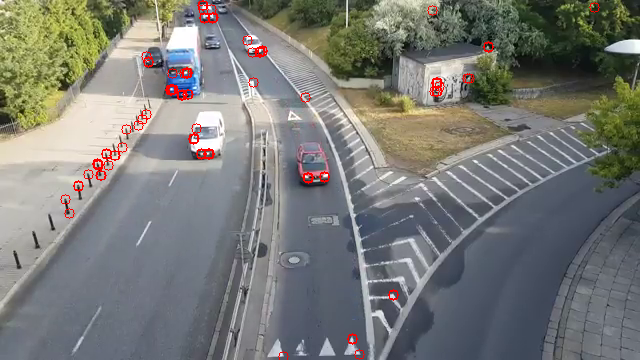

In [109]:
pad_size = 0

first_frame = video[0].copy()

first_frame_gray = np.mean(first_frame, axis=2)

dst = cv2.cornerHarris(first_frame_gray, 2, 3, 0.04)

y, x = np.where(dst > 0.3*dst.max())

for i in range(len(x)):
    first_frame = cv2.circle(first_frame, (x[i], y[i]), 5, (0,0,255))

cv2_imshow(first_frame)

In [110]:
# Problem 1.2

In [111]:
# def is_invertible(a):
#   return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

def bi(arr, x, y):
  x0 = floor(x)
  y0 = floor(y)

  w1 = (x0+1-x)*(y0+1-y)
  w2 = (x0+1-x)*(y-y0)
  w3 = (x-x0)*(y0+1-y)
  w4 = (x-x0)*(y-y0)

  return w1*arr[x0, y0] + w2*arr[x0, y0+1] + w3*arr[x0+1, y0] + w4*arr[x0+1, y0+1]

def lucas_kanade(A, B, x, y):

  # Other info
  N = len(x) # number of tracking points
  P_A = np.vstack((x,y)).T.astype('float32')

  # Hyperparameters
  L = 3 # number of levels in Gaussian pyramid
  w = 3 # window size
  K = 3 # number of L-K iterations

  # Construct Gaussian pyramids
  A_pyr = list([A])
  B_pyr = list([B])

  for l in range(L-1):
    A_pyr = A_pyr + [cv2.pyrDown(A_pyr[-1])]
    B_pyr = B_pyr + [cv2.pyrDown(B_pyr[-1])]

  # Initialize flow estimate
  F = np.zeros((N, 2))

  # Derivative kernels, for later
  d_x = np.array([[-1,0,1]])
  d_y = np.array([[-1,0,1]]).T

  # Loop over Gaussian pyramid
  for l in range(L-1, -1, -1):

    # current pyramid level
    A_l = A_pyr[l]

    ## print(A_l.shape)

    # get spatial gradients
    A_x = cv2.filter2D(src=A_l, ddepth=-1, kernel=d_x)
    A_y = cv2.filter2D(src=A_l, ddepth=-1, kernel=d_y)

    ## print(A_x.shape)

    # get new points
    P_l = P_A / (2**l)

    ## print(P_l)

    # loop from i=0 to i=N-1
    for i in range(N):

      # get point
      p_x, p_y = P_l[i, :] #.astype('int')



      ######## calculate G
      eps = 1e-4

      G = np.diagflat([eps, eps])

      for w_x in range(-w, w+1):
        for w_y in range(-w, w+1):

          # x and y coordinates
          x_c = p_x+w_x
          y_c = p_y+w_y

          try:
            G += np.array([[bi(A_x,x_c, y_c)**2, bi(A_x,x_c, y_c)*bi(A_y,x_c, y_c)],
                         [bi(A_x,x_c, y_c)*bi(A_y,x_c, y_c), bi(A_y,x_c, y_c)**2]])
          except IndexError:
            pass

      ########

      for k in range(K):

        ######## calculate b
        b = np.zeros((2,1), dtype='float32')



        for w_x in range(-w, w+1):
          for w_y in range(-w, w+1):

            # x and y coordinates
            x_c = p_x+w_x
            y_c = p_y+w_y

            try:
              A_t = bi(B_pyr[l], x_c+F[i,0], y_c+F[i,1]) - bi(A_l,x_c, y_c)

              b -= np.array([[bi(A_x,x_c, y_c)*A_t],
                            [bi(A_y,x_c, y_c)*A_t]])
            except IndexError:
              pass

        ########



        F[i,:] += np.matmul(LA.inv(G), b).reshape((2,))


    if l > 0:
      # optical flow guess for next level
      F *= 2

  # location of points in image B
  P_B = P_A + F

  # return new point locations
  return P_B




In [112]:
# Problem 1.3



A = video[0].copy()

A_gray = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)


dst = cv2.cornerHarris(A_gray, 2, 3, 0.04)

y, x = np.where(dst > 0.3*dst.max())

for i in range(len(x)):
    A = cv2.circle(A, (x[i], y[i]), 5, (0,0,255))



im_list = list([cv2.cvtColor(A.astype('uint8'), cv2.COLOR_BGR2RGB)])

for i in range(len(video)-1):

  A = cv2.cvtColor(video[i].copy(), cv2.COLOR_BGR2GRAY)
  B = cv2.cvtColor(video[i+1].copy(), cv2.COLOR_BGR2GRAY)

  P_B = lucas_kanade(A, B, x, y)

  y_s, x_s = B.shape

  x = np.clip(P_B[:,0], 0, x_s-1)
  y = np.clip(P_B[:,1], 0, y_s-1)

  B = video[i+1].copy()

  for i in range(len(x)):
    B = cv2.circle(B, (int(x[i]), int(y[i])), 5, (0,0,255))

  im_list.append(cv2.cvtColor(B.astype('uint8'), cv2.COLOR_BGR2RGB))


# save gif
imageio.mimsave('tracking.gif', im_list, fps=10)


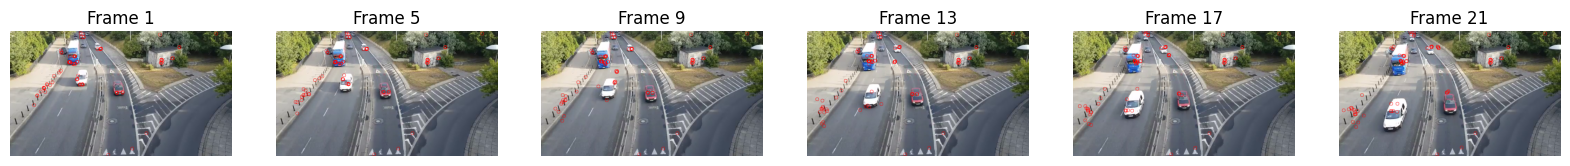

In [113]:

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20,4))

i=0

for col in ax:


      col.set_title('Frame ' + str(i+1))
      col.axis('off')
      col.imshow(im_list[i])

      i += 4

plt.savefig('gif_images.png', dpi=600)

# Problem 3

In [ ]:
# Problem 3.1

# read in images
parrot = cv2.imread("/content/parrot.png").astype('float32')
station = cv2.imread("/content/station.png").astype('float32')

parrot = cv2.cvtColor(parrot, cv2.COLOR_BGR2RGB)
station = cv2.cvtColor(station, cv2.COLOR_BGR2RGB)

# Randomly sample patches
np.random.seed(1)
num_rows, num_cols, k = parrot.shape
xs = np.random.randint(low=0, high=num_cols-16, size=1000)
ys = np.random.randint(low=0, high=num_rows-16, size=1000)


# extract patches
parrot_patches = np.zeros((1000, 16*16*3))
station_patches = np.zeros((1000, 16*16*3))

for i in range(1000):
  parrot_patches[i, :] = parrot[ys[i]:ys[i]+16, xs[i]:xs[i]+16, :].flatten(order='C')
  station_patches[i, :] = station[ys[i]:ys[i]+16, xs[i]:xs[i]+16, :].flatten(order='C')


parrot_mean = np.mean(parrot_patches, axis=0)
parrot_patches -= parrot_mean

station_mean = np.mean(station_patches, axis=0)
station_patches -= station_mean


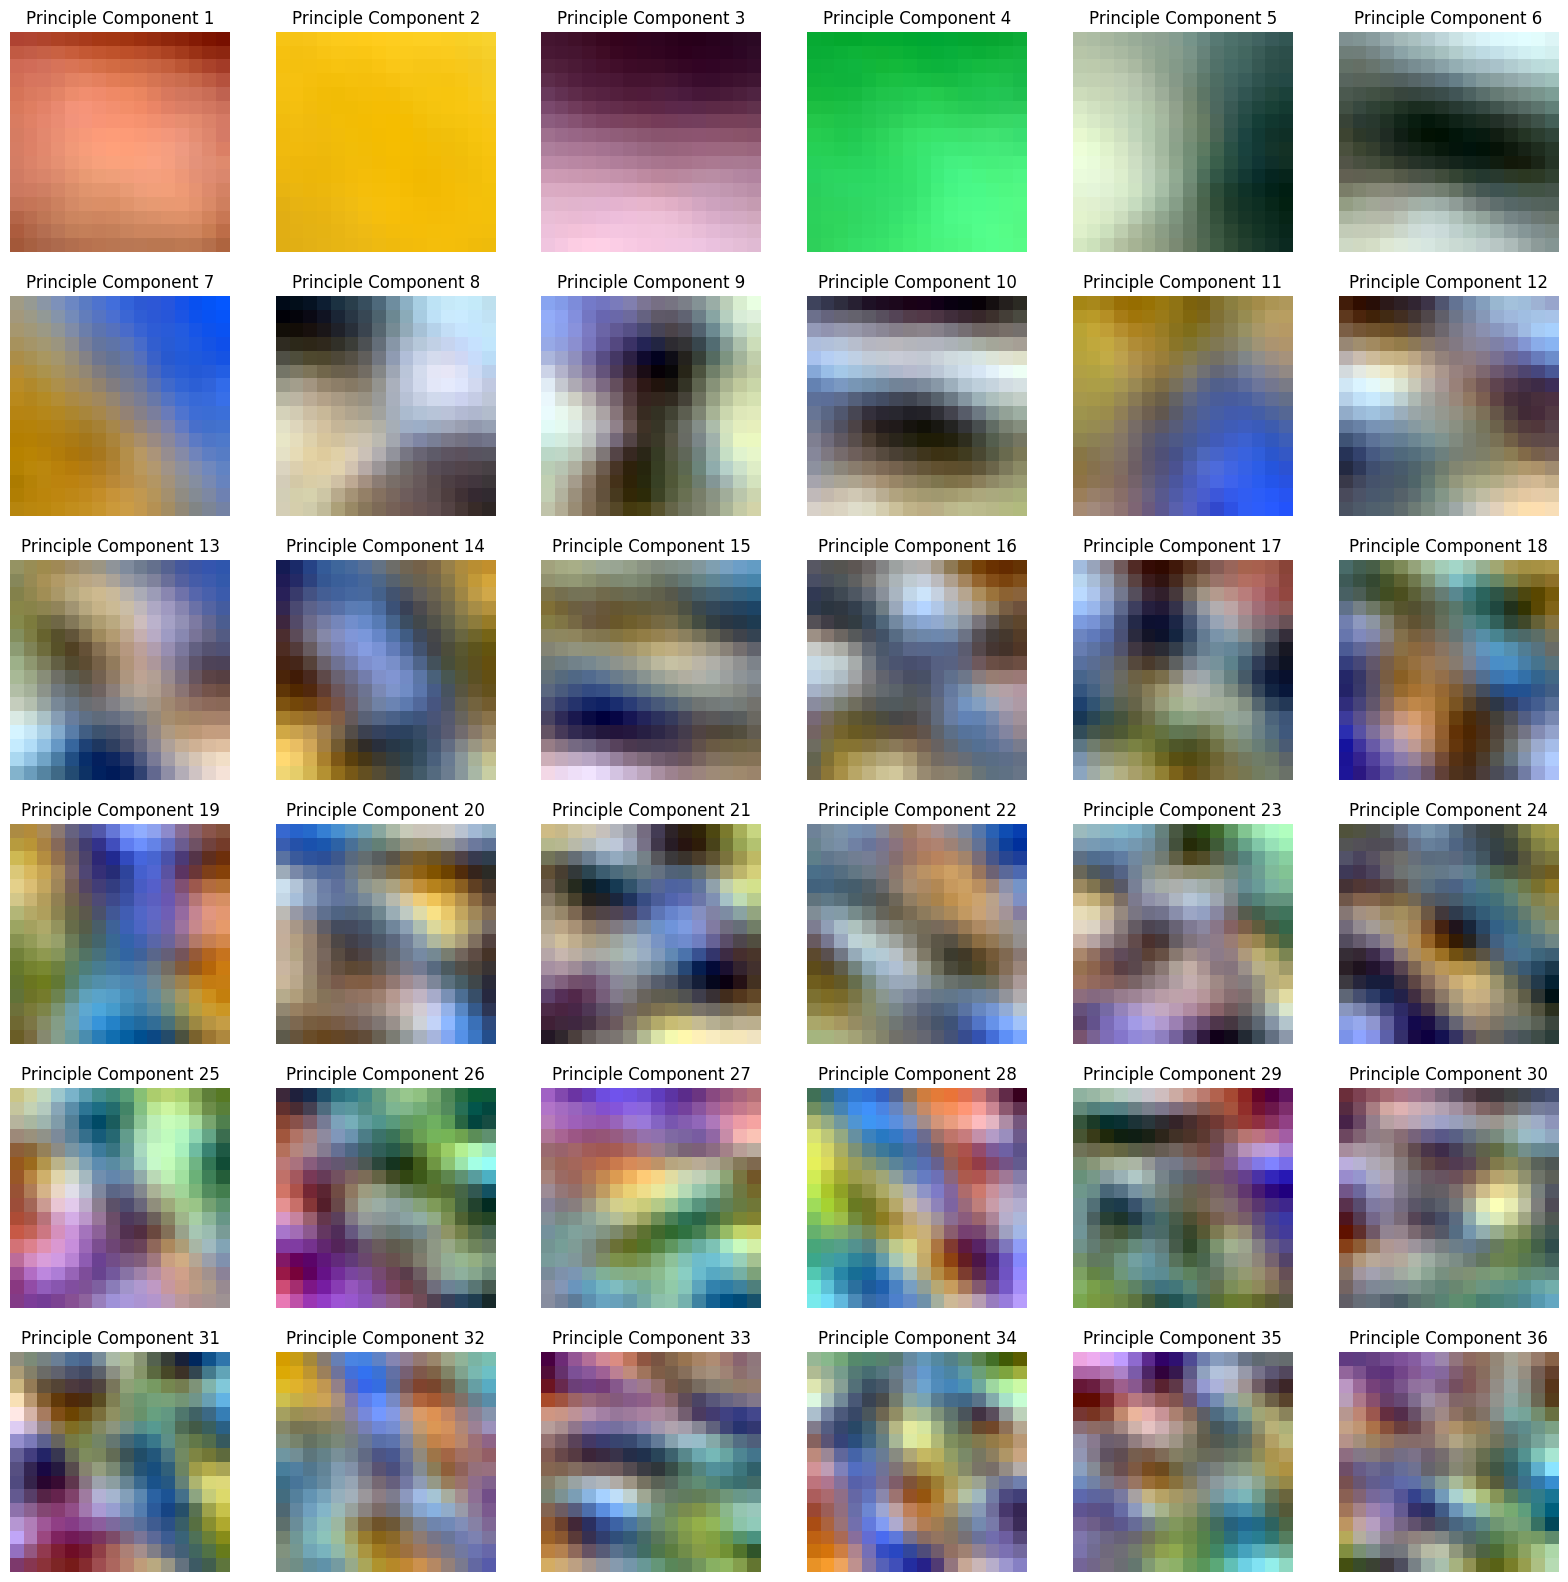

In [ ]:
######## PARROT

C = np.matmul(parrot_patches.T, parrot_patches)


# Calculate and sort eigenvectors
eigenvalues, eigenvectors = LA.eigh(C)
eigenvalues_parrot = eigenvalues[::-1]
eigenvectors_parrot = np.fliplr(eigenvectors)



fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(20,20))

i=0

for row in ax:
    for col in row:

      img = eigenvectors_parrot[:,i]
      img -= img.min()
      img *= 255.0/img.max()
      img = img.reshape((16,16,3), order='C').astype('uint8')

      col.set_title('Principle Component ' + str(i+1))
      col.axis('off')
      col.imshow(img)

      i += 1

plt.savefig('parrot_PCA.png', dpi=600)




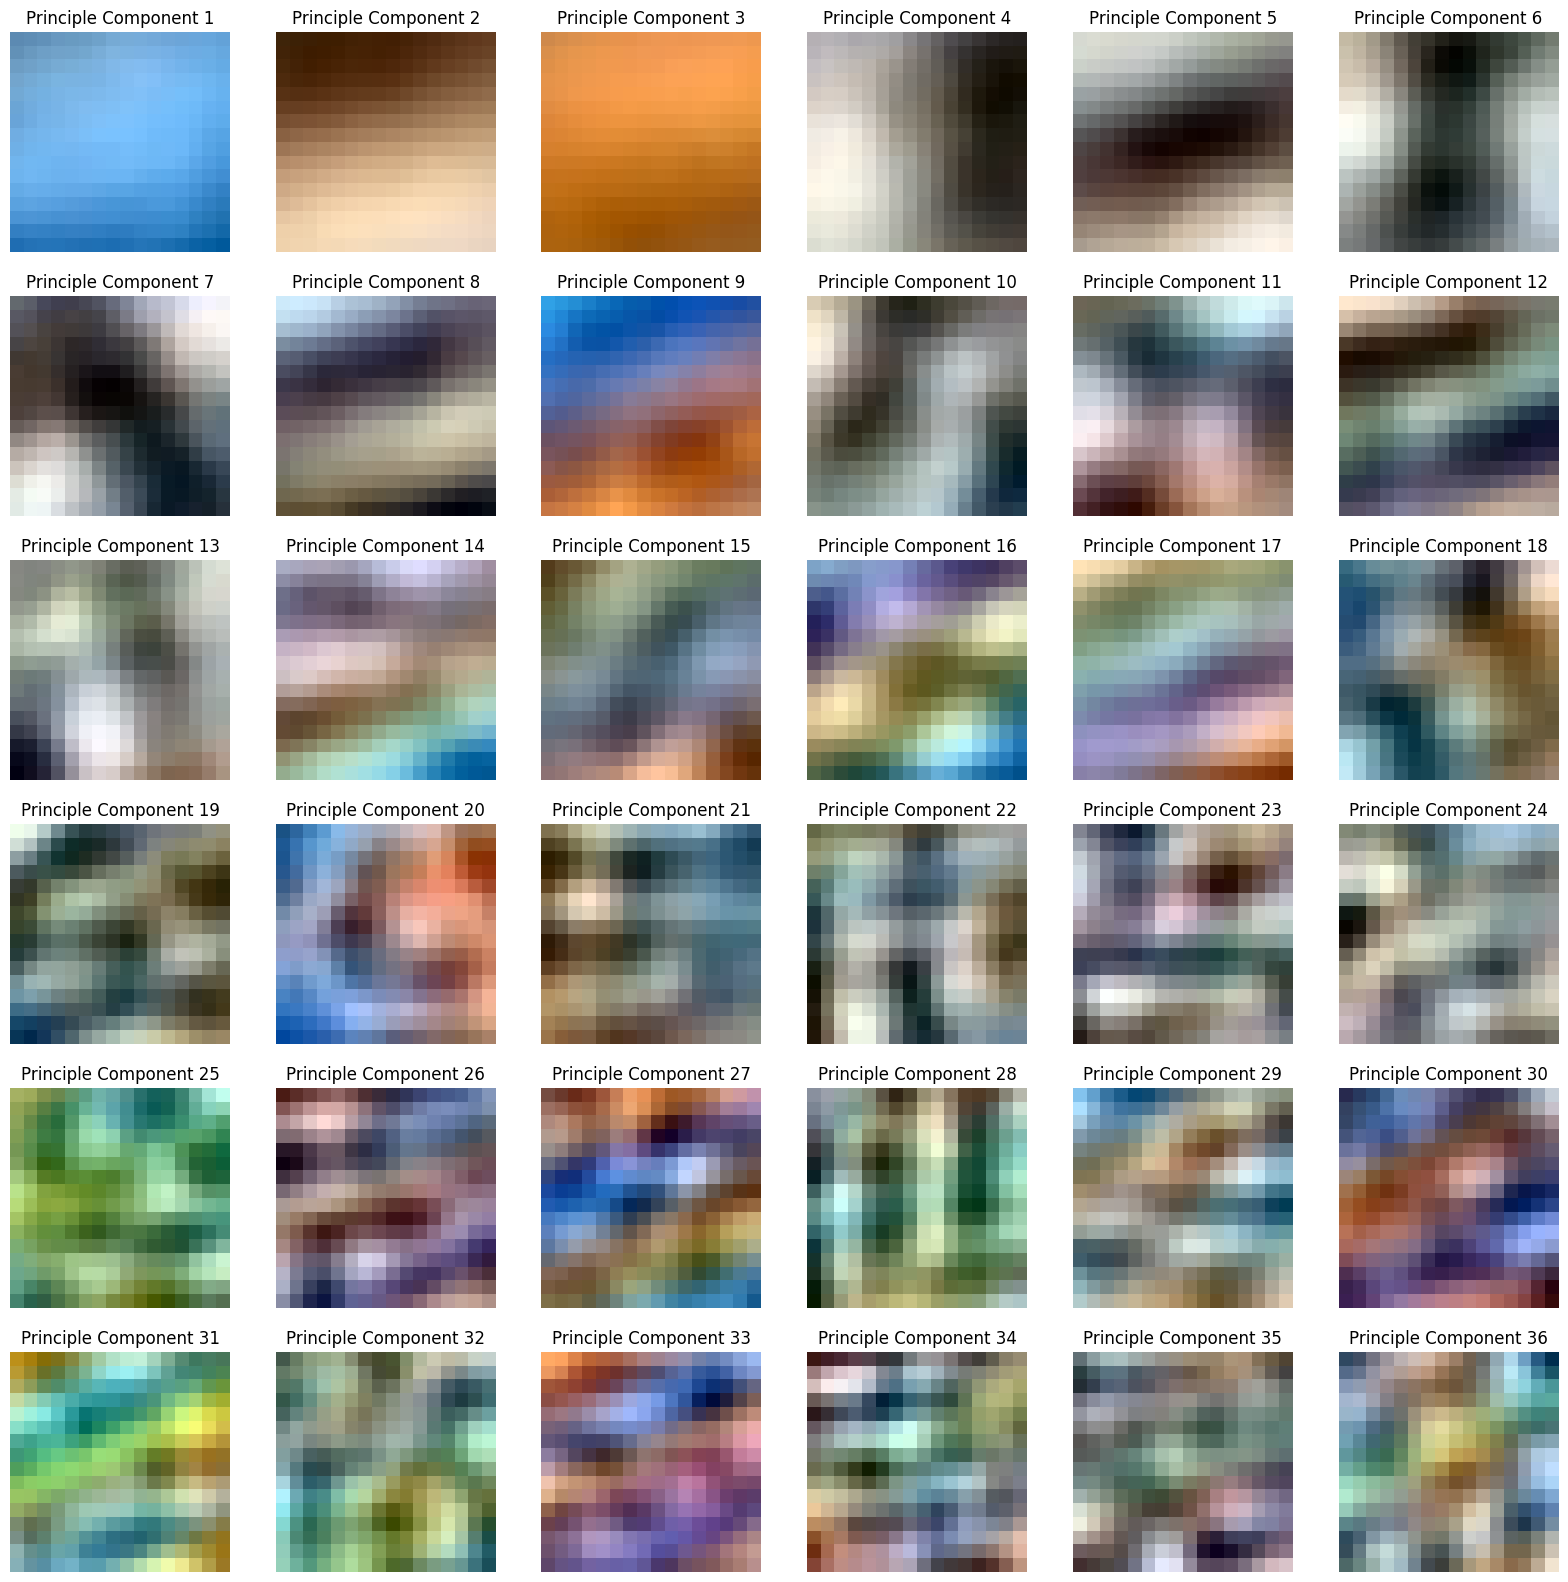

In [ ]:
######## Station

C = np.matmul(station_patches.T, station_patches)


# Calculate and sort eigenvectors
eigenvalues, eigenvectors = LA.eigh(C)
eigenvalues_station = eigenvalues[::-1]
eigenvectors_station = np.fliplr(eigenvectors)



fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(20,20))

i=0

for row in ax:
    for col in row:

      img = eigenvectors_station[:,i]
      img -= img.min()
      img *= 255.0/img.max()
      img = img.reshape((16,16,3), order='C').astype('uint8')

      col.set_title('Principle Component ' + str(i+1))
      col.axis('off')
      col.imshow(img)

      i += 1

plt.savefig('station_PCA.png', dpi=600)

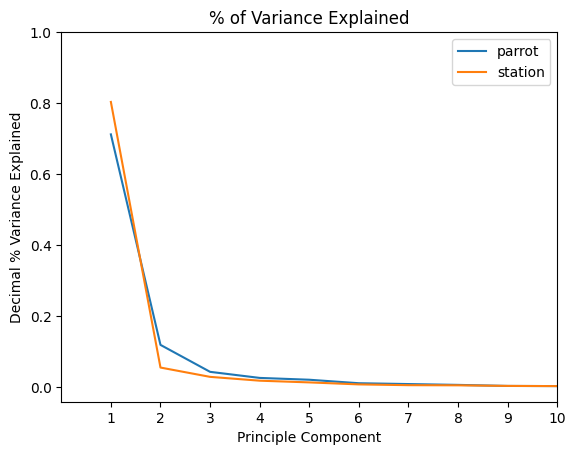

In [ ]:
plt.plot(range(1, 768+1), eigenvalues_parrot/sum(eigenvalues_parrot), label="parrot")
plt.plot(range(1, 768+1), eigenvalues_station/sum(eigenvalues_station), label="station")


plt.title('% of Variance Explained')
plt.xlabel('Principle Component')
plt.ylabel('Decimal % Variance Explained')
plt.legend()

plt.xticks(range(1, 768+1))
plt.yticks(np.linspace(0, 1, 6))

plt.xlim(0, 10)

plt.savefig('explained_variance.png', dpi=600)

In [ ]:
# Problem 3.2

In [ ]:
def compress(img, k):

  rows, cols, _ = img.shape
  rows = int(np.floor(rows/16))
  cols = int(np.floor(cols/16))

  img = img[:rows*16, :cols*16, :]


  N = rows*cols

  # extract patches
  X = np.zeros((N, 16*16*3))

  xs = range(0,cols*16,16)
  ys = range(0,rows*16,16)

  i = 0

  for x in xs:
    for y in ys:
      X[i, :] = img[y:y+16, x:x+16, :].flatten(order='C')
      i += 1

  X_mean = np.mean(X, axis=0)
  X -= X_mean

  #####

  eigenvalues, eigenvectors = LA.eigh(np.matmul(X.T, X))
  eigenvalues_img = eigenvalues[::-1]
  eigenvectors_img = np.fliplr(eigenvectors)

  V_k = eigenvectors_img[:, :k]

  ####

  Z_k = np.matmul(X, V_k)

  X_new = np.matmul(Z_k, V_k.T) + X_mean

  new_img = np.zeros((rows*16, cols*16, 3))

  i = 0
  for x in xs:
    for y in ys:
      new_img[y:y+16, x:x+16, :] = X_new[i, :].reshape((16,16,3), order='C')
      i += 1



  new_img -= new_img.min()
  new_img *= 255.0/new_img.max()

  new_img = new_img.astype('uint8')

  return new_img


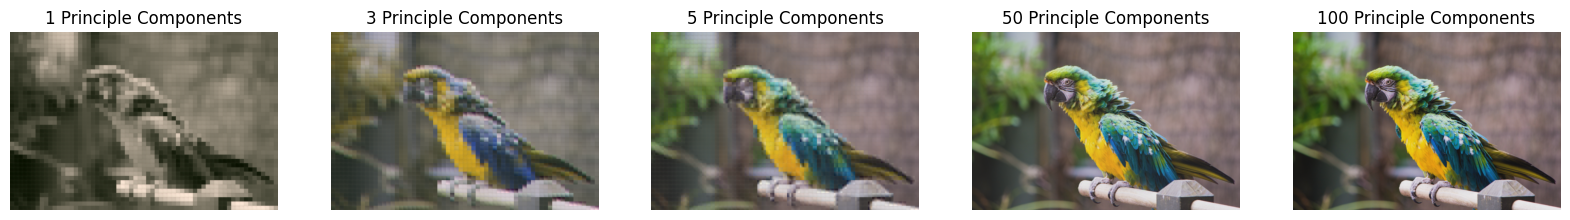

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))

ks = [1, 3, 5, 50, 100]
i = 0
for col in ax:
  col.set_title(str(ks[i]) + ' Principle Components')
  col.axis('off')
  col.imshow(compress(parrot, ks[i]))
  i += 1

plt.savefig('parrot_compression.png', dpi=600)

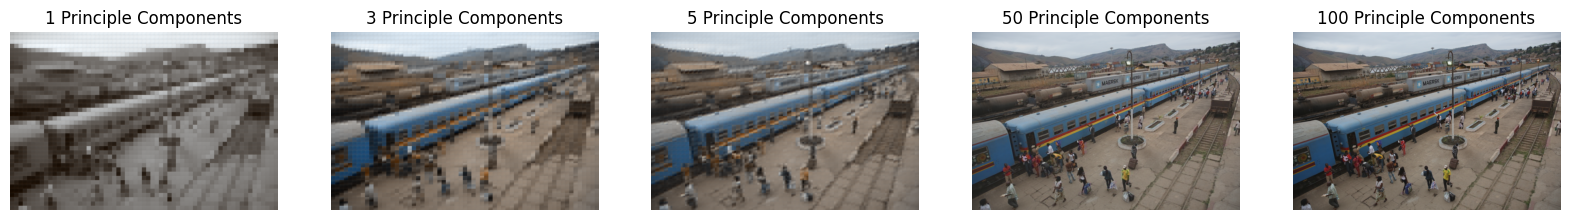

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))

ks = [1, 3, 5, 50, 100]
i = 0
for col in ax:
  col.set_title(str(ks[i]) + ' Principle Components')
  col.axis('off')
  col.imshow(compress(station, ks[i]))
  i += 1

plt.savefig('station_compression.png', dpi=600)